In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../datasets/wicket-1.3.0-beta2.csv')
df = df.drop(columns=['HeuBug', 'HeuBugCount', 'RealBugCount'])

### Split Train/Test 80/20

In [2]:
# split train and test
from sklearn.model_selection import train_test_split

X = df.drop(columns=['RealBug'])
y = df['RealBug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64'])

In [3]:
print(X_train_numeric.shape)
print(X_test_numeric.shape)

(1410, 65)
(353, 65)


## Balanceo de clases usando HCBOU

### Configuración de hiperparámetros HCBOU

In [4]:
import sys
sys.path.append('../utils')

%load_ext autoreload
%autoreload 2
from hcbou import hcbou_balance, get_recommended_params

print("="*50)

# Obtener parámetros recomendados para nuestro dataset
recommended_params = get_recommended_params(X_train_numeric, y_train, scenario='binary_classification')
print(f"Parámetros recomendados: {recommended_params}")

X_train_balanced, y_train_balanced = hcbou_balance(
    X_train_numeric, 
    y_train,
    **recommended_params,
    random_state=42,
    verbose=True
)

Parámetros recomendados: {'max_clusters_maj': 8, 'max_clusters_min': 6, 'k_smote': 3, 'min_cluster_obs': 5}
🚀 HCBOU BALANCING PIPELINE
Original distribution:
  Majority class (False): 1306 samples
  Minority class (True): 104 samples
  Imbalance ratio: 1:12.56

📉 Step 1: Majority Class Undersampling
----------------------------------------
Applying majority class undersampling...
Majority class: 1306 -> 705 samples
Reduction: 54.0%

📈 Step 2: Minority Class Clustering & SMOTE
---------------------------------------------
Finding optimal clusters for minority class...
Optimal clusters: 2
Best silhouette score: 0.7938
Applying SMOTE balancing to minority class...
Cluster distribution: {0: np.int64(91), 1: np.int64(13)}
Cluster weights: {0: np.float64(0.875), 1: np.float64(0.125)}
Cluster 0: 91 -> 616 samples
Cluster 1: 13 -> 88 samples
Minority class: 104 -> 704 samples
Change: 676.9%

🔄 Step 3: Combining Balanced Classes
-----------------------------------

✅ HCBOU BALANCING COMPLETED
F

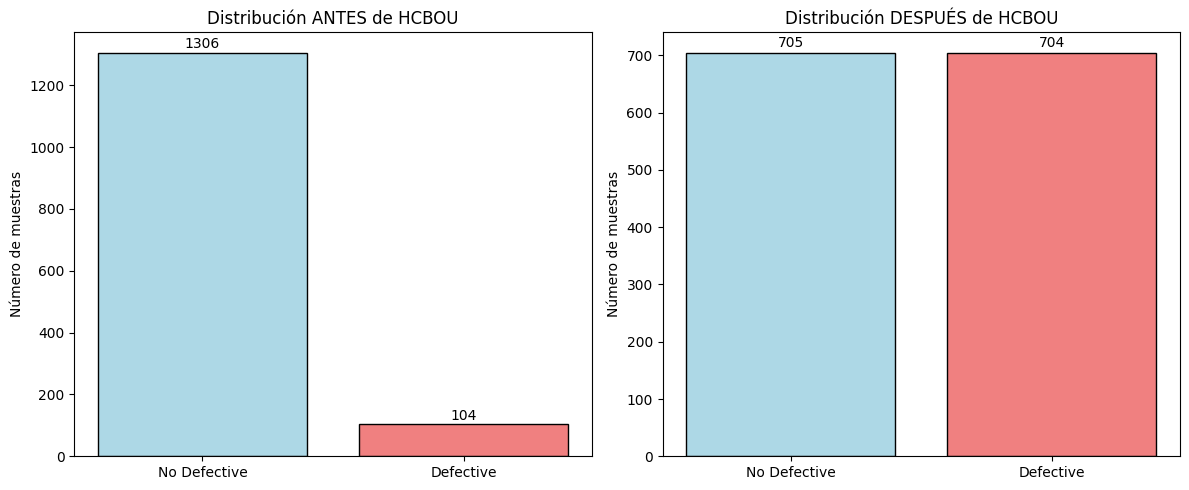


Verificación de calidad de datos balanceados:
Valores nulos en X_train_balanced: 0
Valores infinitos en X_train_balanced: 0
Shape final X_train_balanced: (1409, 65)
Shape final y_train_balanced: (1409,)


In [5]:
# Visualización de la distribución antes y después del balanceo
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Antes del balanceo
before_counts = y_train.value_counts().sort_index()
bars1 = ax1.bar(['No Defective', 'Defective'], before_counts.values, 
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax1.set_title('Distribución ANTES de HCBOU')
ax1.set_ylabel('Número de muestras')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Después del balanceo
after_counts = y_train_balanced.value_counts().sort_index()
bars2 = ax2.bar(['No Defective', 'Defective'], after_counts.values,
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax2.set_title('Distribución DESPUÉS de HCBOU')
ax2.set_ylabel('Número de muestras')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Verificar que no hay valores nulos en los datos balanceados
print(f"\nVerificación de calidad de datos balanceados:")
print(f"Valores nulos en X_train_balanced: {X_train_balanced.isnull().sum().sum()}")
print(f"Valores infinitos en X_train_balanced: {np.isinf(X_train_balanced.values).sum()}")
print(f"Shape final X_train_balanced: {X_train_balanced.shape}")
print(f"Shape final y_train_balanced: {y_train_balanced.shape}")

### Normalización

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_balanced_scaled = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns=X_train_balanced.columns, index=X_train_balanced.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_numeric), columns=X_test_numeric.columns, index=X_test_numeric.index)

In [7]:
X_train_balanced.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,...,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000
mean,0.820440,8.848119,270.980837,3.956707,0.431512,0.983676,1.585522,24.018453,1.471966,14.772889,...,4.827537,3.035486,571.147622,41.450674,0.691646,0.454088,0.083038,2.625266,2.938254,1.382541
std,2.134932,6.148234,350.462716,3.739793,1.845919,0.377477,2.975032,37.861079,0.903412,8.234202,...,5.202784,1.521210,773.827759,109.570808,0.187366,0.151265,0.454839,1.155564,1.302758,1.438811
min,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,25.000000,0.000000,0.243391,0.173087,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,78.000000,1.000000,0.000000,1.000000,0.000000,4.000000,1.000000,9.000000,...,2.000000,2.000000,145.000000,0.000000,0.548387,0.341388,0.000000,2.000000,2.000000,0.000000
50%,0.000000,8.000000,141.000000,3.000000,0.000000,1.000000,1.000000,10.000000,1.000000,13.000000,...,3.000000,3.000000,290.000000,3.000000,0.704035,0.458183,0.000000,3.000000,3.000000,1.000000
75%,1.000000,11.000000,329.000000,6.000000,0.000000,1.000000,2.000000,25.000000,2.000000,18.000000,...,5.000000,4.000000,682.000000,24.000000,0.844537,0.500000,0.000000,3.000000,4.000000,2.000000
max,19.000000,57.000000,3650.000000,24.000000,25.000000,4.000000,52.000000,361.000000,9.000000,83.000000,...,51.000000,10.000000,8133.000000,1022.000000,1.000000,1.000000,4.000000,6.000000,8.000000,8.000000


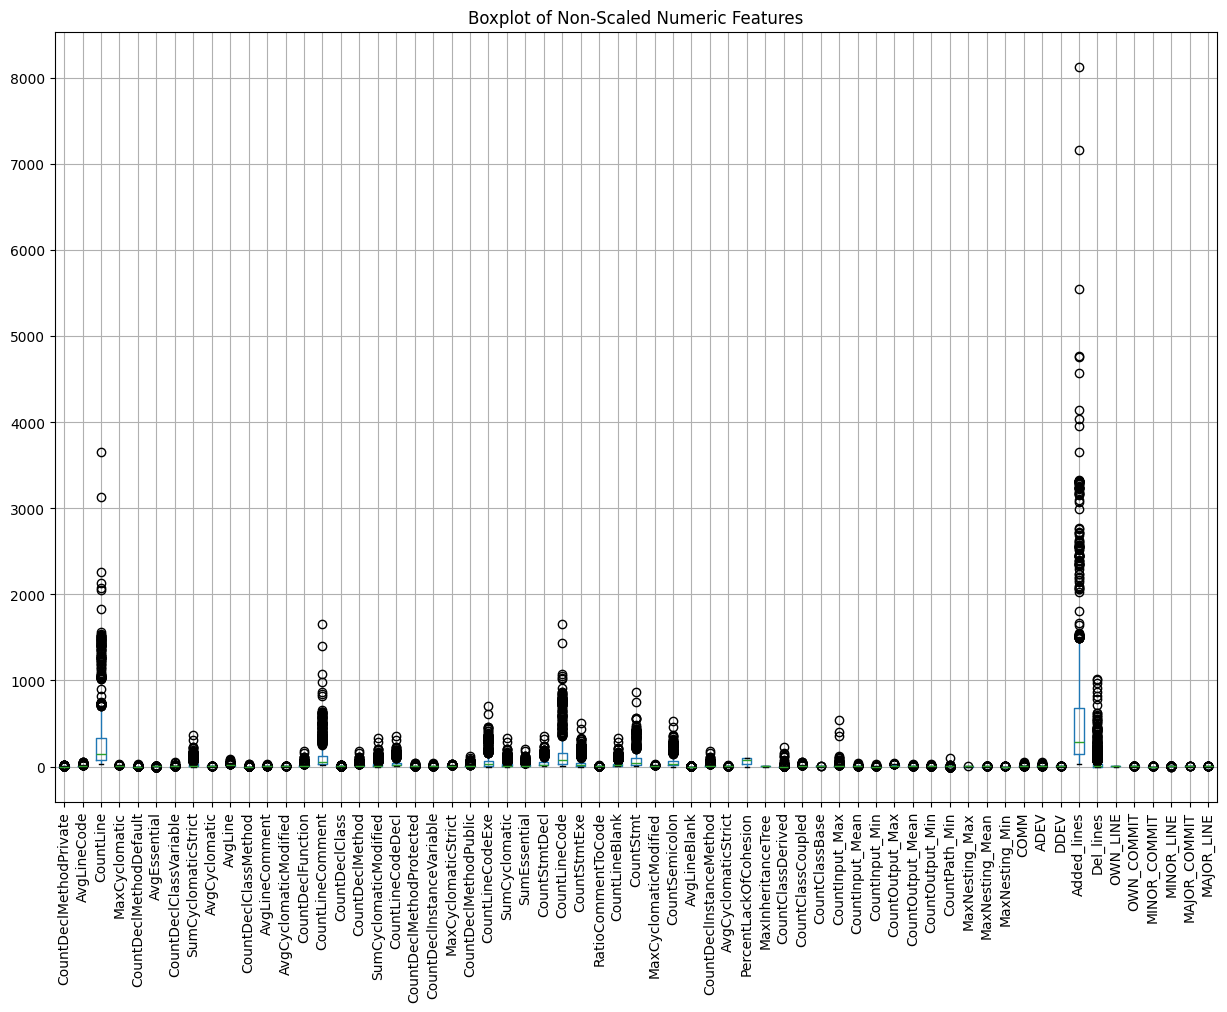

In [8]:
plt.figure(figsize=(15, 10))
X_train_balanced.drop(columns=['CountPath_Max', 'CountPath_Mean']).boxplot()
plt.title('Boxplot of Non-Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [9]:
X_train_balanced_scaled.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,...,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03,1.409000e+03
mean,4.034309e-17,-1.613724e-16,-8.068619e-17,-8.068619e-17,-2.017155e-17,1.916297e-16,4.034309e-17,4.034309e-17,4.034309e-17,-8.068619e-17,...,8.068619e-17,1.613724e-16,4.034309e-17,-8.068619e-17,-2.067584e-16,-2.622301e-16,1.008577e-17,1.008577e-16,-8.068619e-17,-4.034309e-17
std,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,...,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00,1.000355e+00
min,-3.844297e-01,-1.439643e+00,-7.021237e-01,-1.058377e+00,-2.338483e-01,-2.606848e+00,-5.331320e-01,-6.346090e-01,-1.629920e+00,-1.794726e+00,...,-9.282053e-01,-1.996150e+00,-7.060247e-01,-3.784347e-01,-2.393256e+00,-1.858337e+00,-1.826298e-01,-2.272656e+00,-2.256211e+00,-9.612322e-01
25%,-3.844297e-01,-6.261124e-01,-5.508413e-01,-7.908878e-01,-2.338483e-01,4.325938e-02,-5.331320e-01,-5.289221e-01,-5.226118e-01,-7.013355e-01,...,-5.436592e-01,-6.809406e-01,-5.508964e-01,-3.784347e-01,-7.648667e-01,-7.453121e-01,-1.826298e-01,-5.412841e-01,-7.204615e-01,-9.612322e-01
50%,-3.844297e-01,-1.379942e-01,-3.710152e-01,-2.559090e-01,-2.338483e-01,4.325938e-02,-1.968818e-01,-3.703917e-01,-5.226118e-01,-2.153843e-01,...,-3.513862e-01,-2.333587e-02,-3.634497e-01,-3.510454e-01,6.614365e-02,2.708425e-02,-1.826298e-01,3.244018e-01,4.741313e-02,-2.659672e-01
75%,8.413558e-02,3.501241e-01,1.656089e-01,5.465593e-01,-2.338483e-01,4.325938e-02,1.393684e-01,2.593417e-02,5.846965e-01,3.920547e-01,...,3.315994e-02,6.342688e-01,1.433029e-01,-1.593204e-01,8.162900e-01,3.036281e-01,-1.826298e-01,3.244018e-01,8.152878e-01,4.292977e-01
max,8.518311e+00,7.834604e+00,9.645017e+00,5.361369e+00,1.331435e+01,7.993581e+00,1.695188e+01,8.903634e+00,8.335854e+00,8.288762e+00,...,8.877720e+00,4.579897e+00,9.775479e+00,8.952179e+00,1.646317e+00,3.610262e+00,8.614819e+00,2.921459e+00,3.886786e+00,4.600887e+00


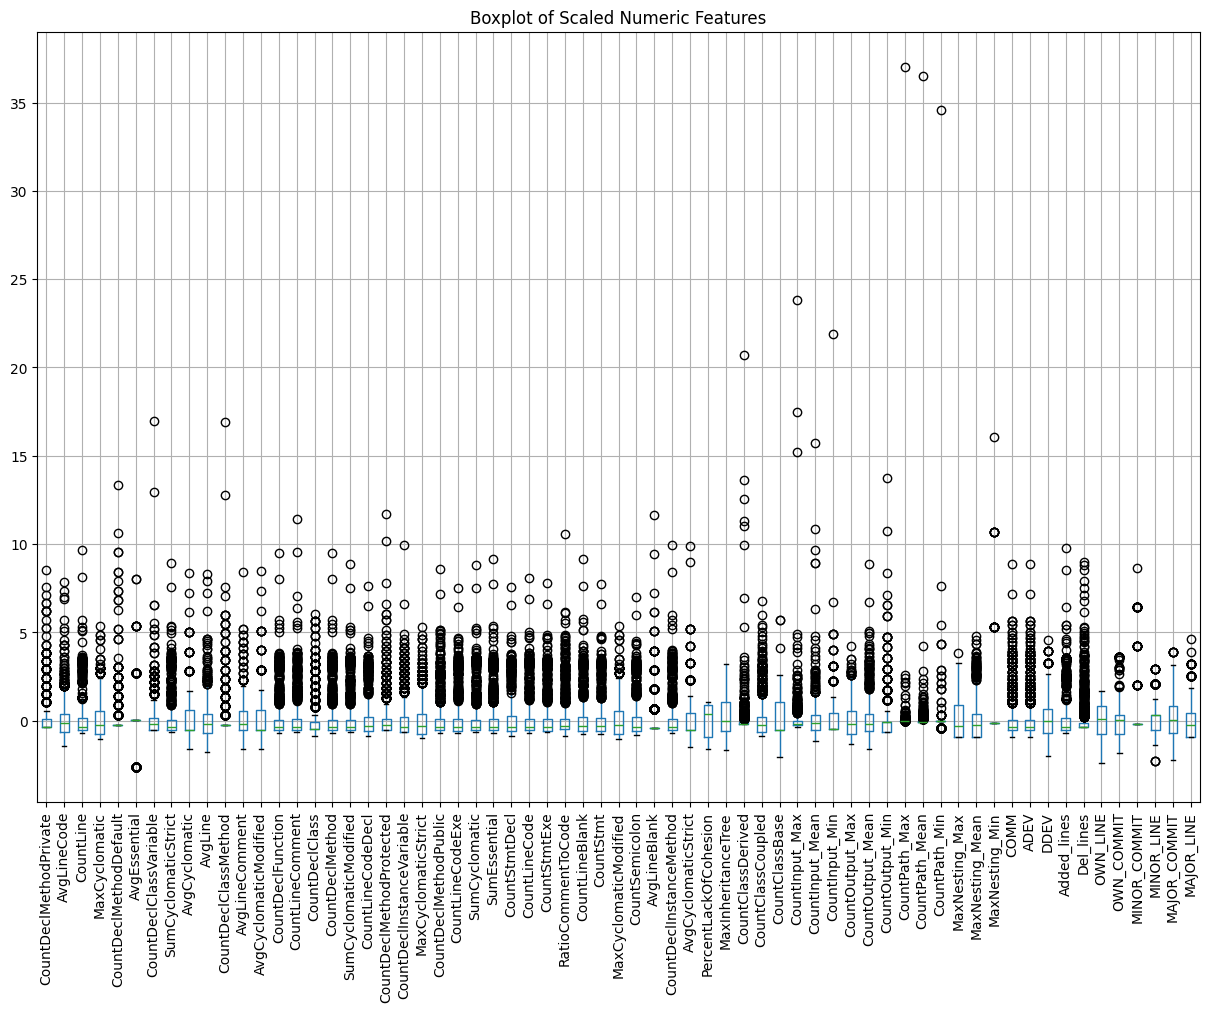

In [10]:
plt.figure(figsize=(15, 10))
X_train_balanced_scaled.boxplot()
plt.title('Boxplot of Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [11]:
# Export the balanced and scaled training set to CSV files
X_train_balanced_scaled.to_csv('../classification/hcbou/wicket-1.3.0-beta2-hcbou-train-features-balanced-scaled.csv', index=False)
y_train_balanced.to_csv('../classification/hcbou/wicket-1.3.0-beta2-hcbou-train-labels-balanced.csv', index=False)
X_test_scaled.to_csv('../classification/hcbou/wicket-1.3.0-beta2-hcbou-test-features-scaled.csv', index=False)
y_test.to_csv('../classification/hcbou/wicket-1.3.0-beta2-hcbou-test-labels.csv', index=False)